##  Рекуррентные нейронные сети для анализа временных рядов

In [209]:
import os
import json
import csv

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 

In [2]:
df = pd.read_csv('../blobs/Sunspots.csv', index_col=0, usecols=[1, 2])
df.index = pd.to_datetime(df.index)
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


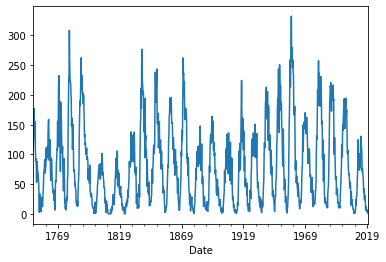

In [3]:
series = df['Monthly Mean Total Sunspot Number']
quarter_series = series.resample('Q').mean()
quarter_series.plot()
plt.show()

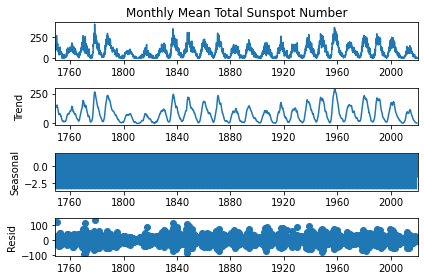

In [4]:
seasonal_decompose(series).plot()
plt.show()

In [93]:
test_size = int(len(df) * 0.2)
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
assert(len(train) + len(test) == len(df))

Let's try ARIMA

In [ ]:
arima_train = train.values.squeeze().tolist()
predictions = []
for t in tqdm(test['Monthly Mean Total Sunspot Number'].values):    
    arima_model = ARIMA(arima_train, order=(5, 1, 0))
    arima_result = arima_model.fit(disp=0)
    [prediction], _, _ = arima_result.forecast()
    predictions.append(prediction)
    arima_train.append(t)

In [ ]:
test = test.assign(Arima=predictions)

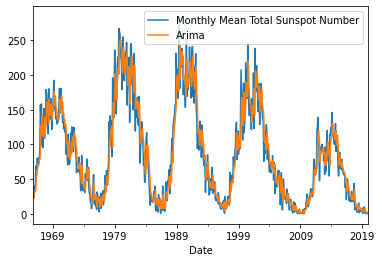

In [173]:
test.plot()
plt.show()

Let's use an RNN

In [219]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1))

In [292]:
model = keras.Sequential([
    keras.layers.GRU(256, return_sequences=True),
    keras.layers.GRU(256, return_sequences=False),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [263]:
LENGTH = 60

In [293]:
generator = keras.preprocessing.sequence.TimeseriesGenerator(
    train_scaled, 
    train_scaled,
    length=LENGTH
)
model.fit(generator, epochs=10)

Epoch 1/10
20/20 [==============================] - 14s 711ms/step - loss: 0.0093
Epoch 2/10
20/20 [==============================] - 10s 490ms/step - loss: 0.0051
Epoch 3/10
20/20 [==============================] - 11s 527ms/step - loss: 0.0044
Epoch 4/10
20/20 [==============================] - 9s 464ms/step - loss: 0.0043
Epoch 5/10
20/20 [==============================] - 9s 465ms/step - loss: 0.0042
Epoch 6/10
20/20 [==============================] - 10s 481ms/step - loss: 0.0042
Epoch 7/10
20/20 [==============================] - 10s 492ms/step - loss: 0.0042
Epoch 8/10
20/20 [==============================] - 10s 477ms/step - loss: 0.0042
Epoch 9/10
20/20 [==============================] - 10s 477ms/step - loss: 0.0041
Epoch 10/10
20/20 [==============================] - 10s 477ms/step - loss: 0.0041


In [294]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 multiple                  198144    
_________________________________________________________________
gru_42 (GRU)                 multiple                  393984    
_________________________________________________________________
dense_22 (Dense)             multiple                  257       
Total params: 592,385
Trainable params: 592,385
Non-trainable params: 0
_________________________________________________________________


In [295]:
data = np.vstack([train_scaled[-LENGTH:], test_scaled])
generator = keras.preprocessing.sequence.TimeseriesGenerator(
    data, 
    data,
    length=LENGTH
)

rnn_y_scaled = model.predict(generator)
rnn_y = scaler.inverse_transform(rnn_y_scaled)
test = test.assign(RNN=rnn_y)

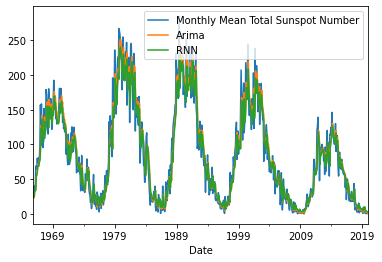

In [297]:
test['Monthly Mean Total Sunspot Number'].plot(legend=True)
test['Arima'].plot(legend=True)
test['RNN'].plot(legend=True)
plt.show()

In [226]:
rmse = np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], test['Arima']))
mean = test['Monthly Mean Total Sunspot Number'].mean()

print('ARIMA predictions')
print(f'RMSE: {rmse}')
print(f'Mean: {mean}')

ARIMA predictions
RMSE: 23.21364547337124
Mean: 87.78692307692307


In [296]:
rmse = np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], test['RNN']))
mean = test['Monthly Mean Total Sunspot Number'].mean()

print('RNN predictions')
print(f'RMSE: {rmse}')
print(f'Mean: {mean}')

RNN predictions
RMSE: 23.395494867207507
Mean: 87.78692307692307
